In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

# Basic packages
import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
from astropy.io import fits
from scipy.io import readsav
from astropy.io import ascii

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import corner

# Chebyshev
from numpy.polynomial.chebyshev import Chebyshev

In [11]:
def wavelength_vac_to_air(vacuum_wavelength):
    return(vacuum_wavelength / (1.0 +  0.05792105/(238.0185 - (0.0001/vacuum_wavelength)**2) + 0.00167917/( 57.362 - (0.0001/vacuum_wavelength)**2)))

In [3]:
# read in the line list 

from astropy.table import Table
linelist = Table.read('linelist.txt',format='ascii')

### read in the data 

In [91]:
# observed spectrum from APOGEE
obs_spec = fits.open('aspcapStar-dr17-2M00482644+0207530.fits')

# sme aspcap 
sme_a = readsav('sme_ir_00482644+0207530_aspcap.out').result[0]

O_01 = readsav('sme_ir_00482644+0207530_aspcap_O_0.1.out').result[0]

Ti_01 = readsav('sme_ir_00482644+0207530_aspcap_Ti_0.1.out').result[0]

# sme galah 
sme_g = readsav('sme_ir_00482644+0207530_galah.out').result[0]

O_01_g = readsav('sme_ir_00482644+0207530_galah_O_0.1.out').result[0]

Ti_01_g = readsav('sme_ir_00482644+0207530_galah_Ti_0.1.out').result[0]


# sme hayes
sme_h = readsav('sme_ir_00482644+0207530_hayes.out').result[0]

O_01_h = readsav('sme_ir_00482644+0207530_hayes_O_0.1.out').result[0]

Ti_01_h = readsav('sme_ir_00482644+0207530_hayes_Ti_0.1.out').result[0]

spectrum = dict()
spectrum['wave_vac_ir'] = 10**(obs_spec[1].header['CRVAL1'] + obs_spec[1].header['CDELT1'] * np.arange(len(obs_spec[1].data)))
spectrum['wave_ir'] = wavelength_vac_to_air(spectrum['wave_vac_ir'])
spectrum['flux_ir'] = obs_spec[1].data
spectrum['noise_ir'] = obs_spec[2].data
spectrum['model_ir_aspcap'] = obs_spec[3].data

In [5]:
len(obs_spec[1].data)

8575

In [14]:

# Open a FITS file
with fits.open('aspcapStar-dr17-2M00482644+0207530.fits') as hdulist:
    # Print the number of HDUs in the file
    print("Number of HDUs:", len(hdulist))

    # Access a specific HDU by index
    primary_hdu = hdulist[0]
    print("Primary HDU header:", primary_hdu.header)

    # Access the data of the primary HDU
    primary_data = primary_hdu.data
    print("Primary HDU data:", primary_data)


Number of HDUs: 5
Primary HDU header: SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  VERSION = '0.17.22 '           / APOGEE software version APOGEE_VER             END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [66]:
spectrum['wave_vac_ir']

array([15100.80154164, 15101.01016837, 15101.21879797, ...,
       16999.33764338, 16999.57249953, 16999.80735892])

### Renormalise the APOGEE observation 

In [6]:
# renomalisation for the spectrum 
# The zero value is unchanged? 

# chip_1 =  [246:3272] /index for the chip one 
# chip_2 = [3585:6080]
# chip_3 = [6345:8335]


flux_renorm = np.zeros(8575)

# chip 1 
wave_1 = spectrum['wave_ir'][246:3272]
observation_1 = spectrum['flux_ir'][246:3272]
synthesis_1 = sme_a['smod'][246:3272]
chebychev_function1 = Chebyshev.fit(wave_1, observation_1/synthesis_1, deg = 3)
renorm_observation1 = observation_1 / chebychev_function1(wave_1)
flux_renorm[246:3272] = renorm_observation1

# chip 2 
wave_2 = spectrum['wave_ir'][3585:6080]
observation_2 = spectrum['flux_ir'][3585:6080]
synthesis_2 = sme_a['smod'][3585:6080]
chebychev_function2 = Chebyshev.fit(wave_2, observation_2/synthesis_2, deg = 3)
renorm_observation2 = observation_2 / chebychev_function2(wave_2)
flux_renorm[3585:6080] = renorm_observation2

# # chip3 
wave_3 = spectrum['wave_ir'][6345:8335]
observation_3 = spectrum['flux_ir'][6345:8335]
synthesis_3 = sme_a['smod'][6345:8335]
chebychev_function3 = Chebyshev.fit(wave_3, observation_3/synthesis_3, deg = 3)
renorm_observation3 = observation_3 / chebychev_function3(wave_3)
flux_renorm[6345:8335] = renorm_observation3

# the flux_renorm is the normalised flux for the APOGEE observation 

### plot for synthetic spectra

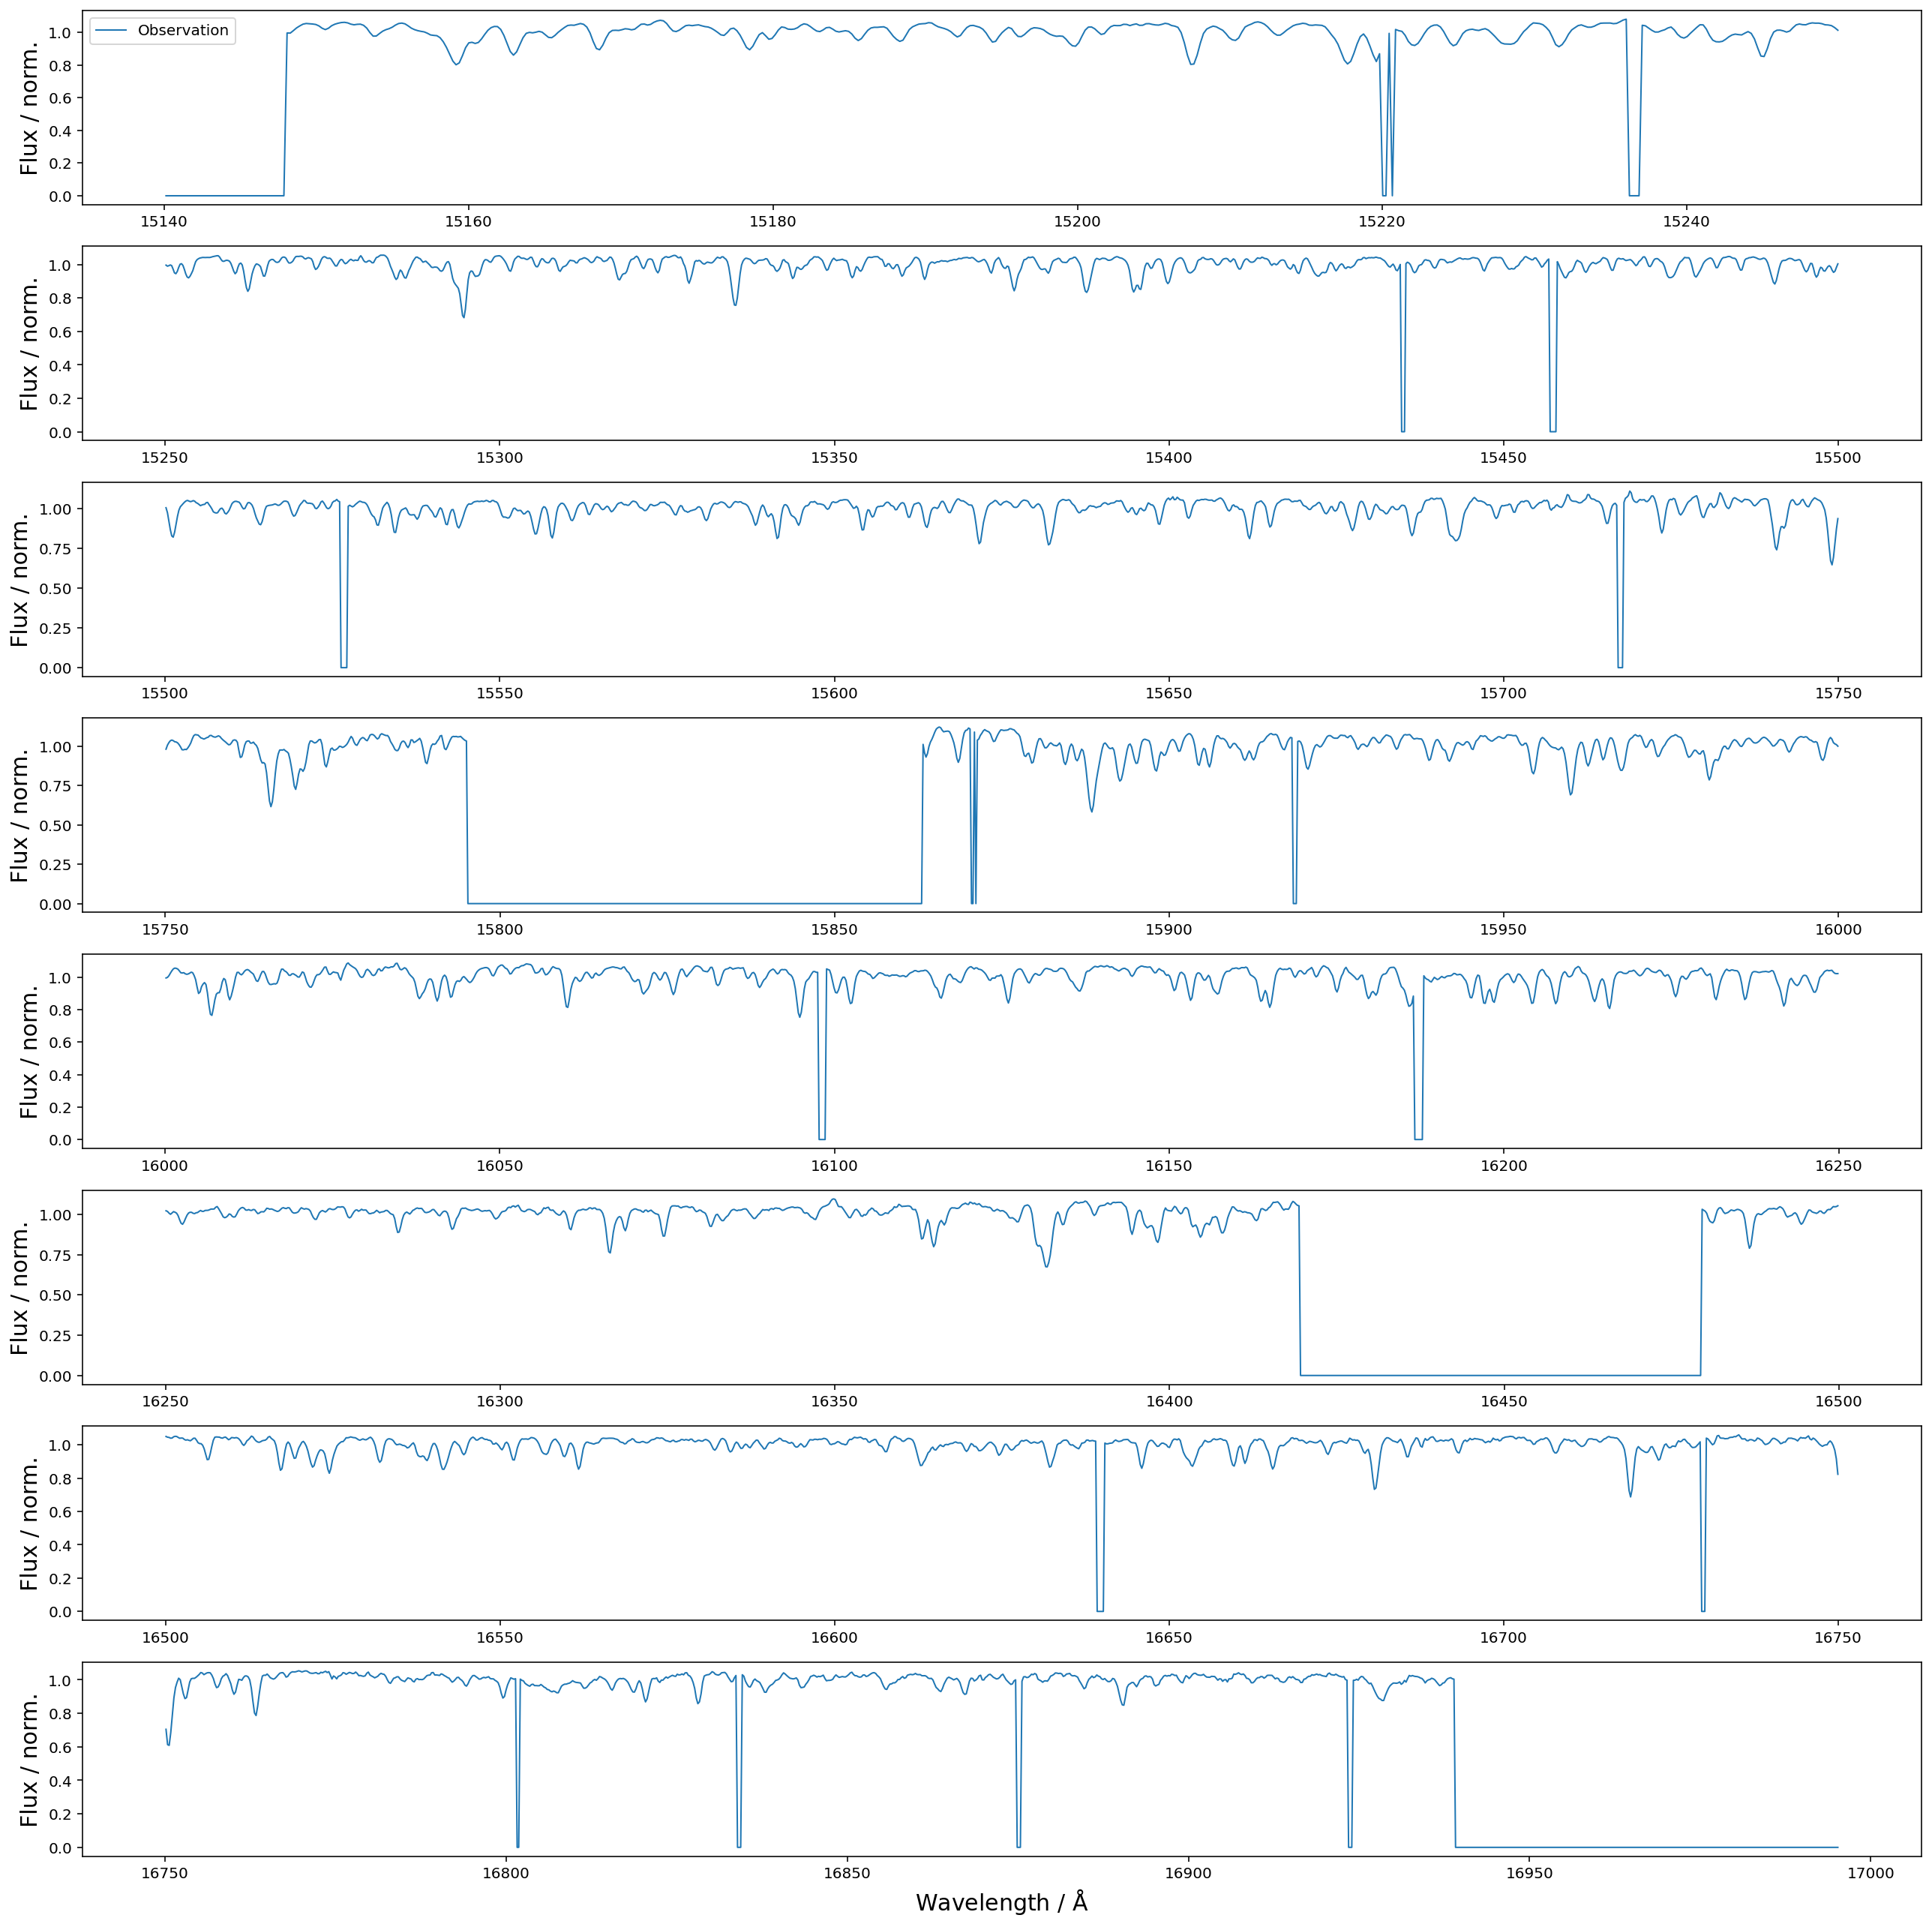

In [7]:
# spectral range 
spectral_ranges = [[15140,15250],[15250,15500],[15500,15750],[15750,16000],[16000,16250],[16250,16500],[16500,16750],[16750,17000]]

f, gs = plt.subplots(8,1,figsize=(18,18))

for panel_index, spectral_range in enumerate(spectral_ranges):

    in_spectral_range = (spectrum['wave_ir'] > spectral_range[0]) & (spectrum['wave_ir'] < spectral_range[1])
    in_spectral_range_s = (sme_a['wave'] > spectral_range[0]) & (sme_a['wave'] < spectral_range[1])
    
    ax = gs[panel_index]
    # line list 
    
#     selec = (spectral_range[0]<linelist['Wavelength']) & (linelist['Wavelength']<spectral_range[1])
#     vline = linelist['Wavelength'][selec]
#     element = linelist['Element'][selec]
#     ax.vlines(vline,ymin=-0.02, ymax=0.02,colors = 'black',lw=0.5)
#     for i in range(len(vline)):
#         if (i % 2) == 0:
#             ax.text(vline[i], 0.01, element[i])
#         else: 
#             ax.text(vline[i], -0.01, element[i])


    
    ax.plot(
        spectrum['wave_ir'][in_spectral_range],
        spectrum['flux_ir'][in_spectral_range],
        label = 'Observation', lw=1
    )
    

#     ax.plot(
#         O_01['wave'][in_spectral_range_s],
#         sme_a['smod'][in_spectral_range_s],#-O_01['smod'][in_spectral_range_s],
#         label = '[O/Fe]+0.1', lw=1
#     )

#     ax.plot(
#         Ti_01['wave'][in_spectral_range_s],
#         sme_a['smod'][in_spectral_range_s],#-Ti_01['smod'][in_spectral_range_s],
#         label = '[Ti/Fe]+0.1', lw=1
#     )



#     ax.plot(
#         sme_a['wave'][in_spectral_range_s],
#         sme_a['smod'][in_spectral_range_s]-flux_renorm[in_spectral_range],
#         label = 'SME_ASPCAP', lw=1
#     )

#     ax.plot(
#         sme_g['wave'][in_spectral_range_s],
#         sme_g['smod'][in_spectral_range_s]-flux_renorm[in_spectral_range],
#         label = 'SME_GALAH', lw=1
#     )

#     ax.plot(
#         sme_h['wave'][in_spectral_range_s],
#         sme_h['smod'][in_spectral_range_s]-flux_renorm[in_spectral_range],
#         label = 'SME_HAYES', lw=1
#     )
        
        
        

    ax.set_ylabel('Flux / norm.',fontsize=15)
    
    #ax.axhline(1.,c='k',lw=0.5,ls='dashed')
    
    if panel_index==0:
        ax.legend(ncol=2)
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
plt.tight_layout()

### change for O and Ti

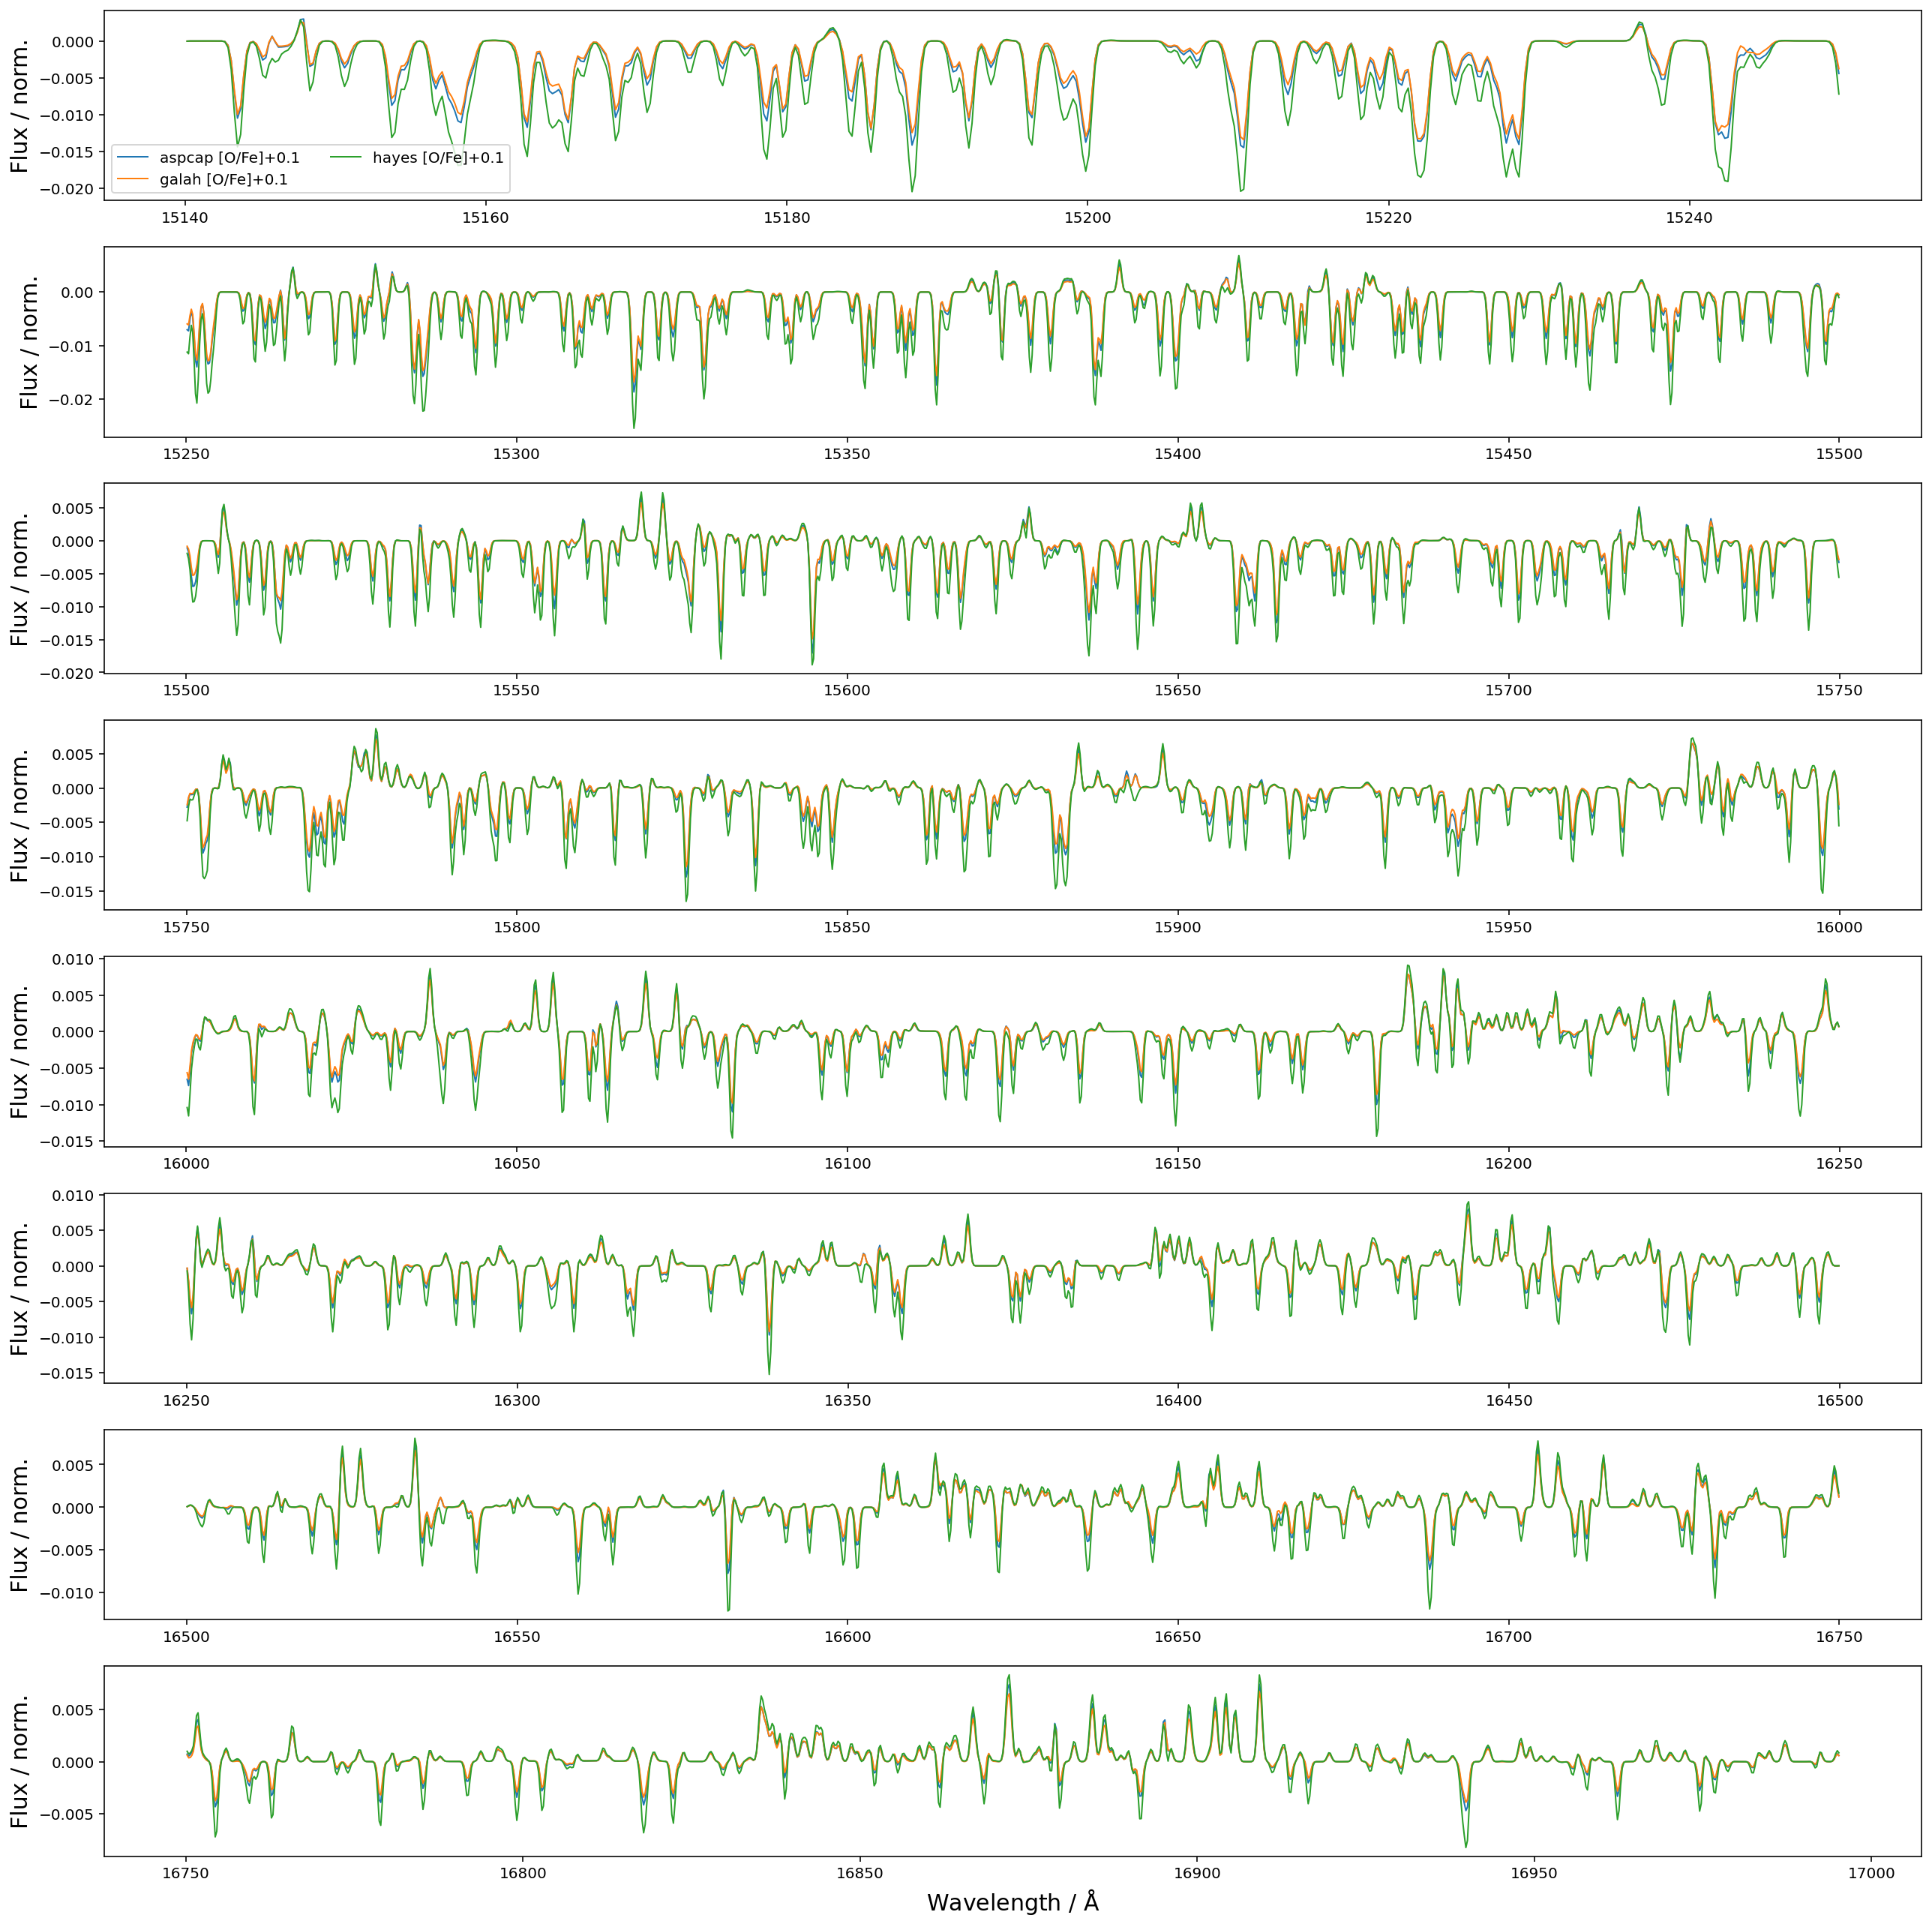

In [8]:
# spectral range 
spectral_ranges = [[15140,15250],[15250,15500],[15500,15750],[15750,16000],[16000,16250],[16250,16500],[16500,16750],[16750,17000]]

f, gs = plt.subplots(8,1,figsize=(18,18))

for panel_index, spectral_range in enumerate(spectral_ranges):

    in_spectral_range = (spectrum['wave_ir'] > spectral_range[0]) & (spectrum['wave_ir'] < spectral_range[1])
    in_spectral_range_s = (sme_a['wave'] > spectral_range[0]) & (sme_a['wave'] < spectral_range[1])
    
    ax = gs[panel_index]
    # line list 
    
#     selec = (spectral_range[0]<linelist['Wavelength']) & (linelist['Wavelength']<spectral_range[1])
#     vline = linelist['Wavelength'][selec]
#     element = linelist['Element'][selec]
#     ax.vlines(vline,ymin=-0.02, ymax=0.02,colors = 'black',lw=0.5)
#     for i in range(len(vline)):
#         if (i % 2) == 0:
#             ax.text(vline[i], 0.01, element[i])
#         else: 
#             ax.text(vline[i], -0.01, element[i])


    
#     ax.plot(
#         spectrum['wave_ir'][in_spectral_range],
#         flux_renorm[in_spectral_range],
#         label = 'Observation', lw=1
#     )
    

    ax.plot(
        O_01['wave'][in_spectral_range_s],
        sme_a['smod'][in_spectral_range_s]-O_01['smod'][in_spectral_range_s],
        label = 'aspcap [O/Fe]+0.1', lw=1
    )

#     ax.plot(
#         Ti_01['wave'][in_spectral_range_s],
#         sme_a['smod'][in_spectral_range_s]-Ti_01['smod'][in_spectral_range_s],
#         label = 'aspcap [Ti/Fe]+0.1', lw=1
#     )
    
    ax.plot(
        O_01_g['wave'][in_spectral_range_s],
        sme_g['smod'][in_spectral_range_s]-O_01_g['smod'][in_spectral_range_s],
        label = 'galah [O/Fe]+0.1', lw=1
    )

#     ax.plot(
#         Ti_01_g['wave'][in_spectral_range_s],
#         sme_g['smod'][in_spectral_range_s]-Ti_01_g['smod'][in_spectral_range_s],
#         label = 'galah [Ti/Fe]+0.1', lw=1
#     )
    
    ax.plot(
        O_01_h['wave'][in_spectral_range_s],
        sme_h['smod'][in_spectral_range_s]-O_01_h['smod'][in_spectral_range_s],
        label = 'hayes [O/Fe]+0.1', lw=1
    )

#     ax.plot(
#         Ti_01_h['wave'][in_spectral_range_s],
#         sme_h['smod'][in_spectral_range_s]-Ti_01_h['smod'][in_spectral_range_s],
#         label = 'hayes [Ti/Fe]+0.1', lw=1
#     )    
        

    ax.set_ylabel('Flux / norm.',fontsize=15)
    
    #ax.axhline(1.,c='k',lw=0.5,ls='dashed')
    
    if panel_index==0:
        ax.legend(ncol=2)
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
plt.tight_layout()

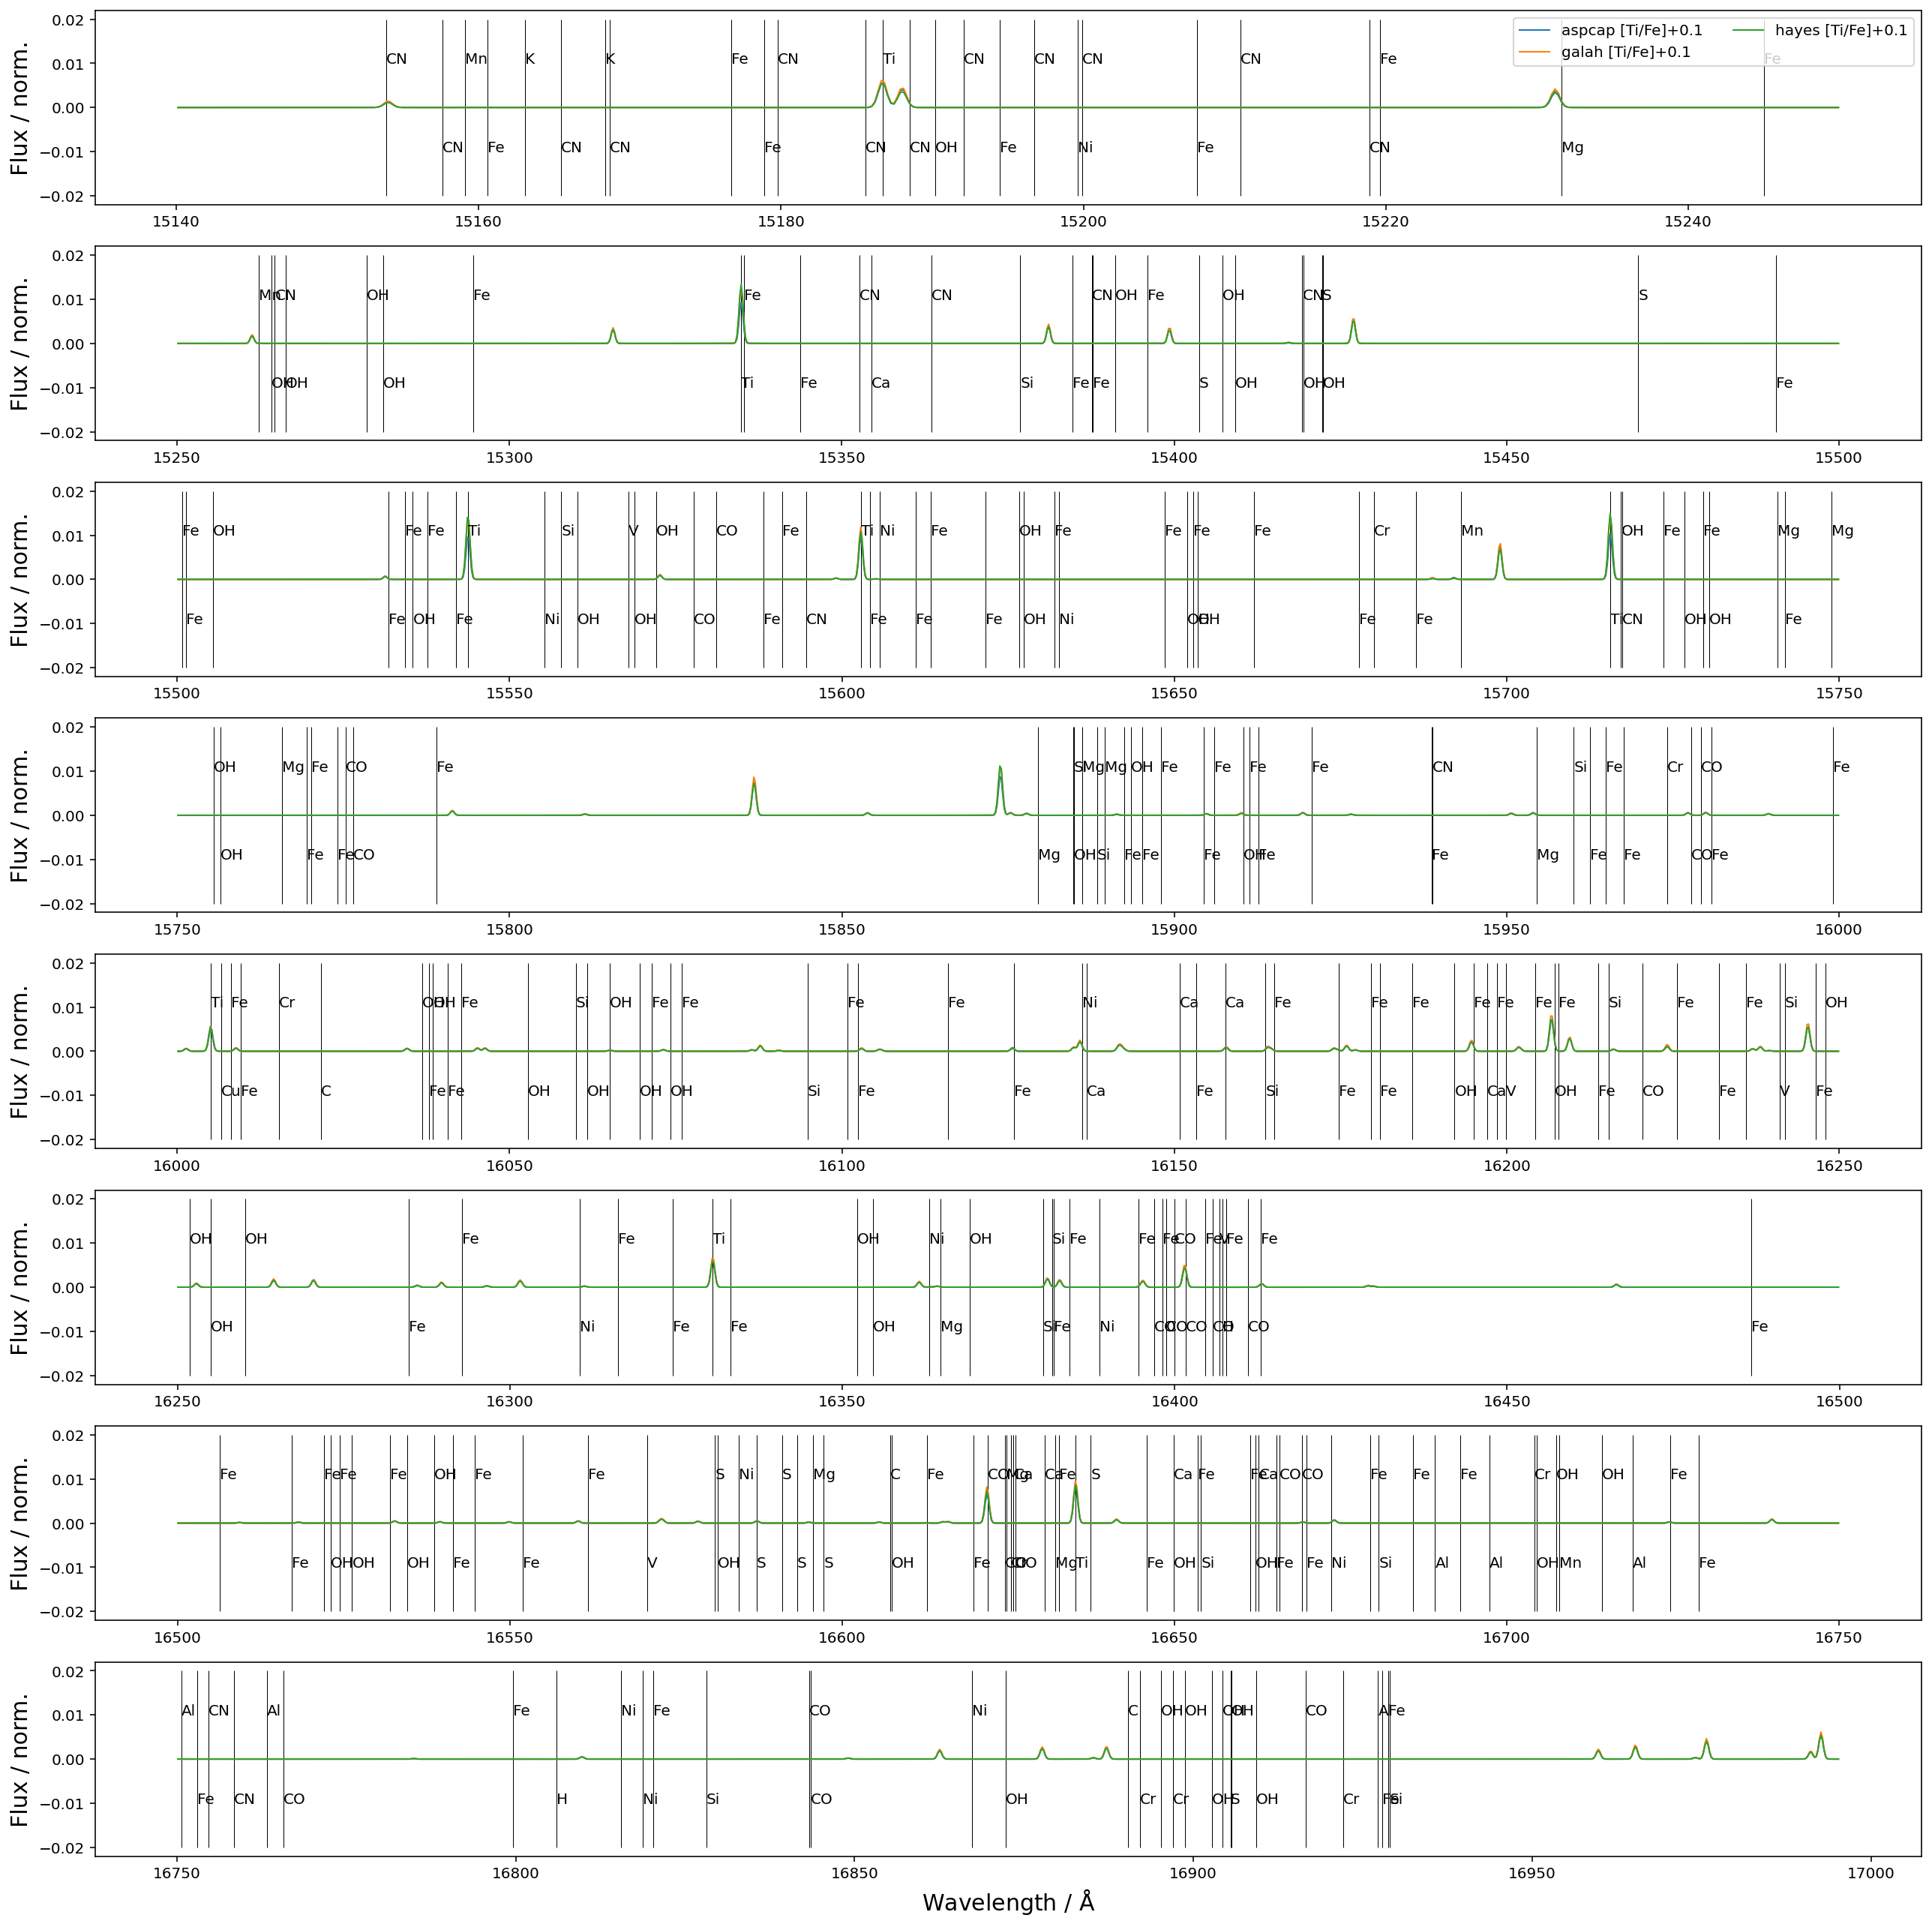

In [63]:
# spectral range 
spectral_ranges = [[15140,15250],[15250,15500],[15500,15750],[15750,16000],[16000,16250],[16250,16500],[16500,16750],[16750,17000]]

f, gs = plt.subplots(8,1,figsize=(18,18))

for panel_index, spectral_range in enumerate(spectral_ranges):

    in_spectral_range = (spectrum['wave_ir'] > spectral_range[0]) & (spectrum['wave_ir'] < spectral_range[1])
    in_spectral_range_s = (sme_a['wave'] > spectral_range[0]) & (sme_a['wave'] < spectral_range[1])
    
    ax = gs[panel_index]
    # line list 
    
    selec = (spectral_range[0]<linelist['Wavelength']) & (linelist['Wavelength']<spectral_range[1])
    vline = linelist['Wavelength'][selec]
    element = linelist['Element'][selec]
    ax.vlines(vline,ymin=-0.02, ymax=0.02,colors = 'black',lw=0.5)
    for i in range(len(vline)):
        if (i % 2) == 0:
            ax.text(vline[i], 0.01, element[i])
        else: 
            ax.text(vline[i], -0.01, element[i])


    
#     ax.plot(
#         spectrum['wave_ir'][in_spectral_range],
#         flux_renorm[in_spectral_range],
#         label = 'Observation', lw=1
#     )
    

#     ax.plot(
#         O_01['wave'][in_spectral_range_s],
#         sme_a['smod'][in_spectral_range_s]-O_01['smod'][in_spectral_range_s],
#         label = 'aspcap [O/Fe]+0.1', lw=1
#     )

    ax.plot(
        Ti_01['wave'][in_spectral_range_s],
        sme_a['smod'][in_spectral_range_s]-Ti_01['smod'][in_spectral_range_s],
        label = 'aspcap [Ti/Fe]+0.1', lw=1
    )
    
#     ax.plot(
#         O_01_g['wave'][in_spectral_range_s],
#         sme_g['smod'][in_spectral_range_s]-O_01_g['smod'][in_spectral_range_s],
#         label = 'galah [O/Fe]+0.1', lw=1
#     )

    ax.plot(
        Ti_01_g['wave'][in_spectral_range_s],
        sme_g['smod'][in_spectral_range_s]-Ti_01_g['smod'][in_spectral_range_s],
        label = 'galah [Ti/Fe]+0.1', lw=1
    )
    
#     ax.plot(
#         O_01_h['wave'][in_spectral_range_s],
#         sme_h['smod'][in_spectral_range_s]-O_01_h['smod'][in_spectral_range_s],
#         label = 'hayes [O/Fe]+0.1', lw=1
#     )

    ax.plot(
        Ti_01_h['wave'][in_spectral_range_s],
        sme_h['smod'][in_spectral_range_s]-Ti_01_h['smod'][in_spectral_range_s],
        label = 'hayes [Ti/Fe]+0.1', lw=1
    )    
        

    ax.set_ylabel('Flux / norm.',fontsize=15)
    
    #ax.axhline(1.,c='k',lw=0.5,ls='dashed')
    
    if panel_index==0:
        ax.legend(ncol=2)
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
plt.tight_layout()

# Read in the observed spectra 

In [4]:
# observed spectra 
obs_spec = Table.read('00204121-7202433.fits') # this file already neglect the empty flux between the chips 


In [5]:


# sme aspcap 
sme_a = readsav('sme_ir_00204121-7202433_aspcap.out').result[0]

O_01 = readsav('sme_ir_00204121-7202433_aspcap_O_0.1.out').result[0]

Ti_01 = readsav('sme_ir_00204121-7202433_aspcap_Ti_0.1.out').result[0]

# sme galah 
sme_g = readsav('sme_ir_00204121-7202433_galah.out').result[0]

O_01_g = readsav('sme_ir_00204121-7202433_galah_O_0.1.out').result[0]

Ti_01_g = readsav('sme_ir_00204121-7202433_galah_Ti_0.1.out').result[0]


# sme hayes
sme_h = readsav('sme_ir_00204121-7202433_hayes.out').result[0]

O_01_h = readsav('sme_ir_00204121-7202433_hayes_O_0.1.out').result[0]

Ti_01_h = readsav('sme_ir_00204121-7202433_hayes_Ti_0.1.out').result[0]

# spectrum = dict()
# spectrum['wave_vac_ir'] = 10**(obs_spec[1].header['CRVAL1'] + obs_spec[1].header['CDELT1'] * np.arange(len(obs_spec[1].data)))
# spectrum['wave_ir'] = wavelength_vac_to_air(spectrum['wave_vac_ir'])
# spectrum['flux_ir'] = obs_spec[1].data
# spectrum['noise_ir'] = obs_spec[2].data
# spectrum['model_ir_aspcap'] = obs_spec[3].data

# Renormalise the spectra

In [12]:
obs_spec['WAVE_VAC']=obs_spec['WAVE']
obs_spec['WAVE']=wavelength_vac_to_air(obs_spec['WAVE'])

In [23]:
obs_spec['WAVE']

15148.499

In [ ]:
import numpy as np

# create an array
arr = np.random.rand(1000)

# compute the 1st and 99th percentiles
p1 = np.percentile(arr, 1)
p99 = np.percentile(arr, 99)

# create a boolean mask where values are between the 1st and 99th percentile
mask = (arr > p1) & (arr < p99)

# apply the mask to the array
filtered_arr = arr[mask]


In [16]:
len(sme_a['wave'])

8575

In [24]:
sme_a['wave'][248:]

array([15148.49956383, 15148.70884953, 15148.91813812, ...,
       16994.70454612, 16994.93933827, 16995.17413365])

## plot the data

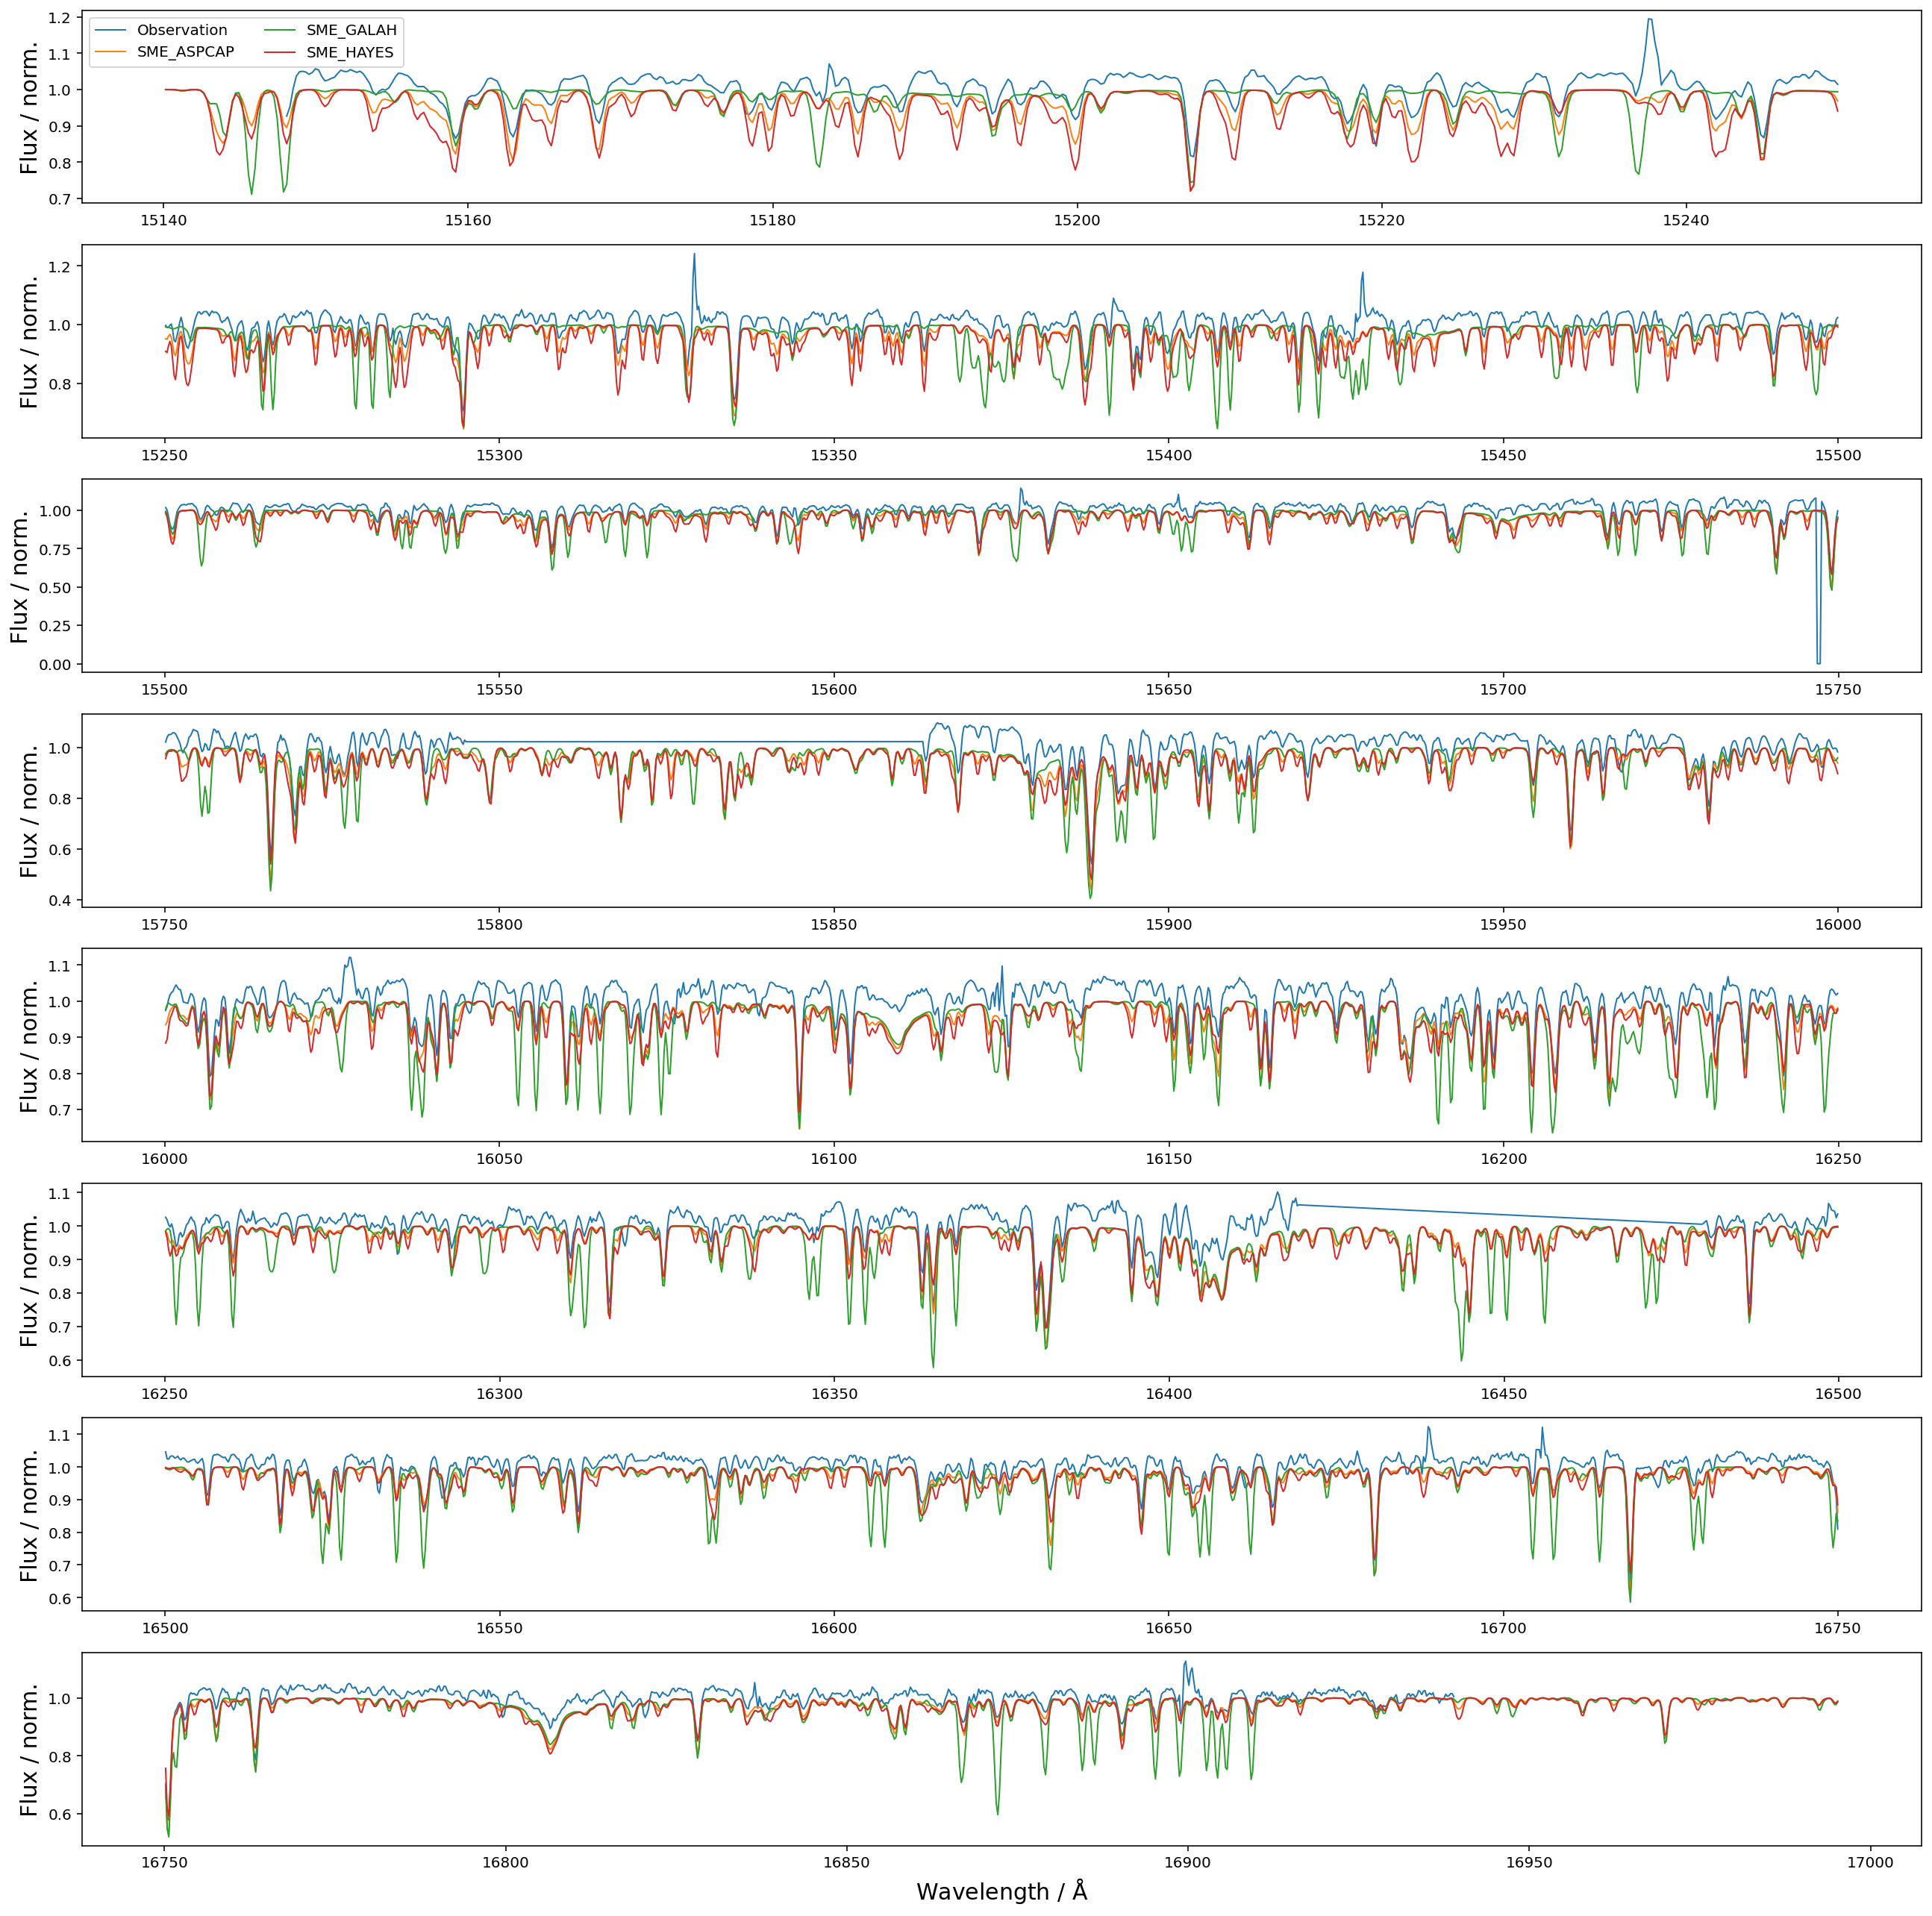

In [13]:
# spectral range 
spectral_ranges = [[15140,15250],[15250,15500],[15500,15750],[15750,16000],[16000,16250],[16250,16500],[16500,16750],[16750,17000]]

f, gs = plt.subplots(8,1,figsize=(18,18))

for panel_index, spectral_range in enumerate(spectral_ranges):

    in_spectral_range = (obs_spec['WAVE'] > spectral_range[0]) & (obs_spec['WAVE'] < spectral_range[1]) # spectra range for the observed spectra 
    in_spectral_range_s = (sme_a['wave'] > spectral_range[0]) & (sme_a['wave'] < spectral_range[1]) # spectra range for the synthetic spectra 
    
    
    ax = gs[panel_index]
    # line list 
    
#     selec = (spectral_range[0]<linelist['Wavelength']) & (linelist['Wavelength']<spectral_range[1])
#     vline = linelist['Wavelength'][selec]
#     element = linelist['Element'][selec]
#     ax.vlines(vline,ymin=-0.02, ymax=0.02,colors = 'black',lw=0.5)
#     for i in range(len(vline)):
#         if (i % 2) == 0:
#             ax.text(vline[i], 0.01, element[i])
#         else: 
#             ax.text(vline[i], -0.01, element[i])


    
    ax.plot(
        obs_spec['WAVE'][in_spectral_range],
        obs_spec['SPEC'][in_spectral_range],
        label = 'Observation', lw=1
    )
    

    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        sme_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_ASPCAP', lw=1
    )

    ax.plot(
        sme_g['wave'][in_spectral_range_s],
        sme_g['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_GALAH', lw=1
    )

    ax.plot(
        sme_h['wave'][in_spectral_range_s],
        sme_h['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_HAYES', lw=1
    )
        
        
        

    ax.set_ylabel('Flux / norm.',fontsize=15)
    
    #ax.axhline(1.,c='k',lw=0.5,ls='dashed')
    
    if panel_index==0:
        ax.legend(ncol=2)
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
plt.tight_layout()

In [119]:
# observed spectra 
obs_spec = Table.read('00202281-7201135.fits') # this file already neglect the empty flux between the chips 


# sme aspcap 
sme_a = readsav('sme_ir_00202281-7201135_aspcap.out').result[0]

O_01 = readsav('sme_ir_00202281-7201135_aspcap_O_0.1.out').result[0]

Ti_01 = readsav('sme_ir_00202281-7201135_aspcap_Ti_0.1.out').result[0]

# sme galah 
sme_g = readsav('sme_ir_00202281-7201135_galah.out').result[0]

O_01_g = readsav('sme_ir_00202281-7201135_galah_O_0.1.out').result[0]

Ti_01_g = readsav('sme_ir_00202281-7201135_galah_Ti_0.1.out').result[0]


# sme hayes
sme_h = readsav('sme_ir_00202281-7201135_hayes.out').result[0]

O_01_h = readsav('sme_ir_00202281-7201135_hayes_O_0.1.out').result[0]

Ti_01_h = readsav('sme_ir_00202281-7201135_hayes_Ti_0.1.out').result[0]

# spectrum = dict()
# spectrum['wave_vac_ir'] = 10**(obs_spec[1].header['CRVAL1'] + obs_spec[1].header['CDELT1'] * np.arange(len(obs_spec[1].data)))
# spectrum['wave_ir'] = wavelength_vac_to_air(spectrum['wave_vac_ir'])
# spectrum['flux_ir'] = obs_spec[1].data
# spectrum['noise_ir'] = obs_spec[2].data
# spectrum['model_ir_aspcap'] = obs_spec[3].data

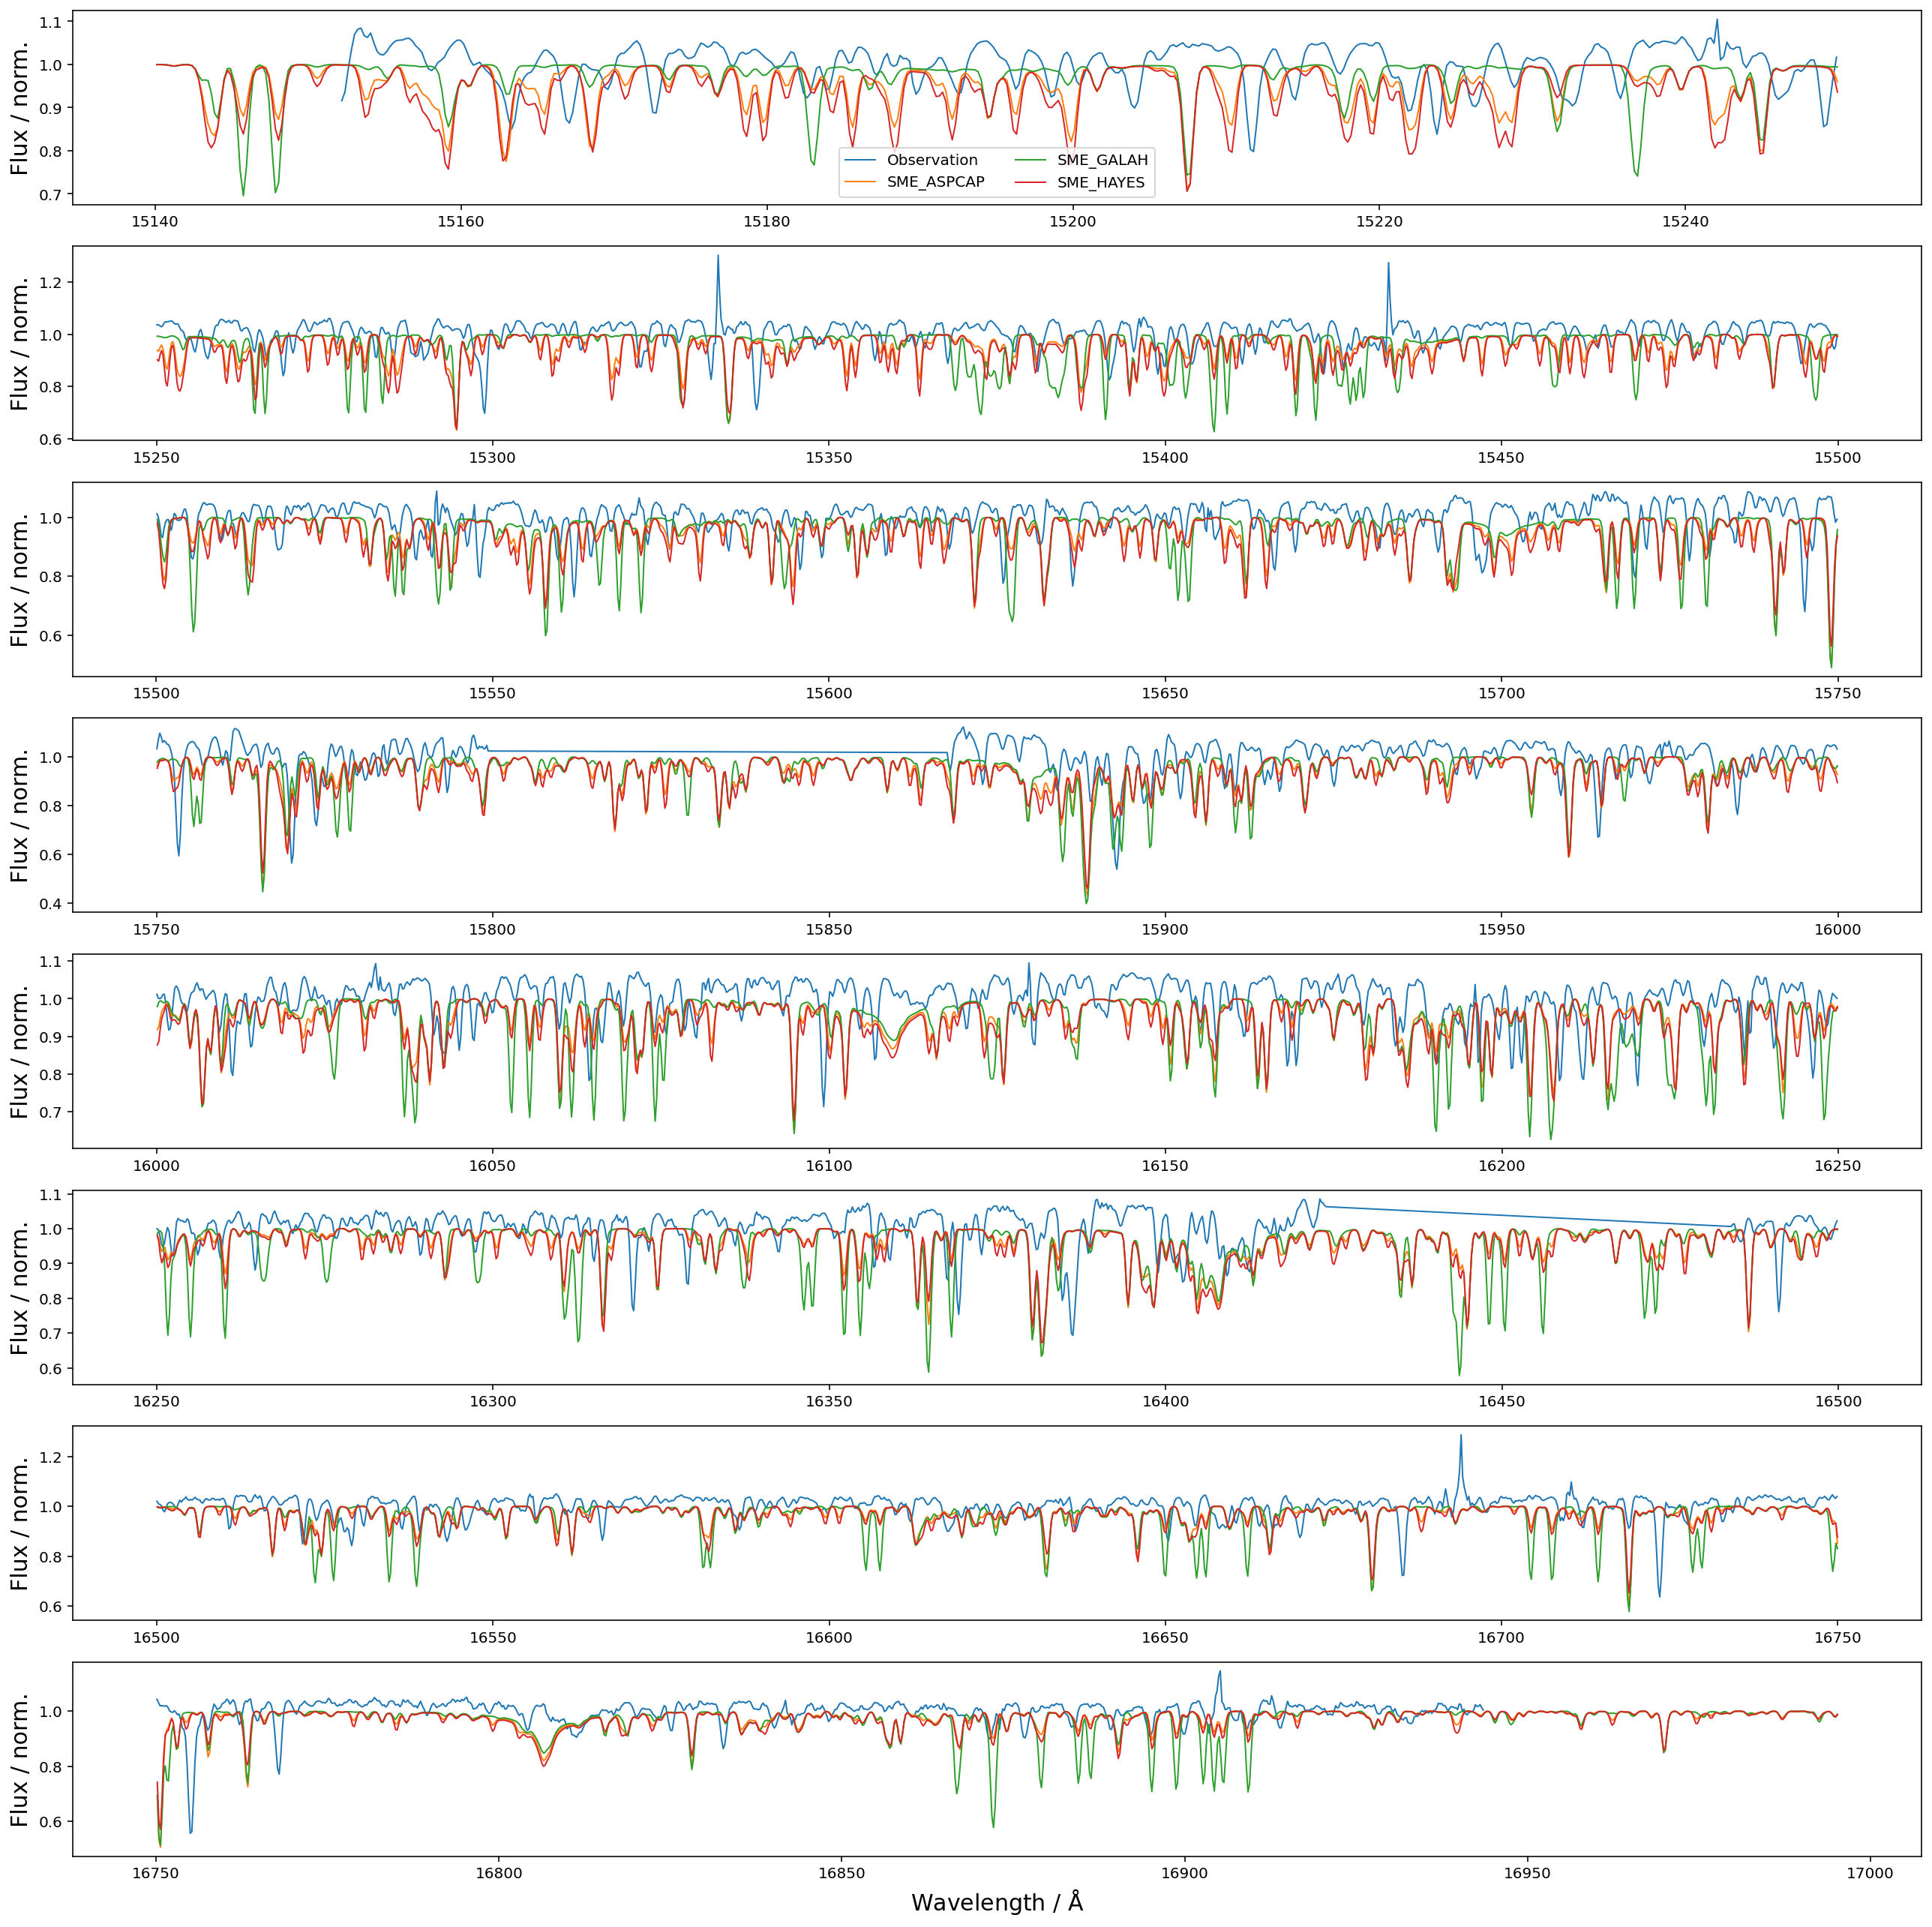

In [120]:
# spectral range 
spectral_ranges = [[15140,15250],[15250,15500],[15500,15750],[15750,16000],[16000,16250],[16250,16500],[16500,16750],[16750,17000]]

f, gs = plt.subplots(8,1,figsize=(18,18))

for panel_index, spectral_range in enumerate(spectral_ranges):

    in_spectral_range = (obs_spec['WAVE'] > spectral_range[0]) & (obs_spec['WAVE'] < spectral_range[1]) # spectra range for the observed spectra 
    in_spectral_range_s = (sme_a['wave'] > spectral_range[0]) & (sme_a['wave'] < spectral_range[1]) # spectra range for the synthetic spectra 
    
    
    ax = gs[panel_index]
    # line list 
    
#     selec = (spectral_range[0]<linelist['Wavelength']) & (linelist['Wavelength']<spectral_range[1])
#     vline = linelist['Wavelength'][selec]
#     element = linelist['Element'][selec]
#     ax.vlines(vline,ymin=-0.02, ymax=0.02,colors = 'black',lw=0.5)
#     for i in range(len(vline)):
#         if (i % 2) == 0:
#             ax.text(vline[i], 0.01, element[i])
#         else: 
#             ax.text(vline[i], -0.01, element[i])


    
    ax.plot(
        obs_spec['WAVE'][in_spectral_range],
        obs_spec['SPEC'][in_spectral_range],
        label = 'Observation', lw=1
    )
    



    ax.plot(
        sme_a['wave'][in_spectral_range_s],
        sme_a['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_ASPCAP', lw=1
    )

    ax.plot(
        sme_g['wave'][in_spectral_range_s],
        sme_g['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_GALAH', lw=1
    )

    ax.plot(
        sme_h['wave'][in_spectral_range_s],
        sme_h['smod'][in_spectral_range_s],#-flux_renorm[in_spectral_range],
        label = 'SME_HAYES', lw=1
    )
        
        
        

    ax.set_ylabel('Flux / norm.',fontsize=15)
    
    #ax.axhline(1.,c='k',lw=0.5,ls='dashed')
    
    if panel_index==0:
        ax.legend(ncol=2)
ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
plt.tight_layout()

In [49]:
# renomalisation for the spectrum 
# The zero value is unchanged? 

# chip_1 =  [246:3272] /index for the chip one 
# chip_2 = [3585:6080]
# chip_3 = [6345:8335]


flux_renorm = np.zeros(8575)

# chip 1 
wave_1 = spectrum['wave_ir'][246:3272]
observation_1 = spectrum['flux_ir'][246:3272]
synthesis_1 = sme_a['smod'][246:3272]
chebychev_function1 = Chebyshev.fit(wave_1, observation_1/synthesis_1, deg = 3)
renorm_observation1 = observation_1 / chebychev_function1(wave_1)
flux_renorm[246:3272] = renorm_observation1

# chip 2 
wave_2 = spectrum['wave_ir'][3585:6080]
observation_2 = spectrum['flux_ir'][3585:6080]
synthesis_2 = sme_a['smod'][3585:6080]
chebychev_function2 = Chebyshev.fit(wave_2, observation_2/synthesis_2, deg = 3)
renorm_observation2 = observation_2 / chebychev_function2(wave_2)
flux_renorm[3585:6080] = renorm_observation2

# # chip3 
wave_3 = spectrum['wave_ir'][6345:8335]
observation_3 = spectrum['flux_ir'][6345:8335]
synthesis_3 = sme_a['smod'][6345:8335]
chebychev_function3 = Chebyshev.fit(wave_3, observation_3/synthesis_3, deg = 3)
renorm_observation3 = observation_3 / chebychev_function3(wave_3)
flux_renorm[6345:8335] = renorm_observation3

# the flux_renorm is the normalised flux for the APOGEE observation 

In [ ]:
renorm_observation1 = observation / chebychev_function1(wave)

In [ ]:
# for different chips 
renorm_observation1 = observation / chebychev_function1(wave)
renorm_observation2 = observation / chebychev_function2(wave)
renorm_observation3 = observation / chebychev_function3(wave)